In [ ]:
import pandas as pd
import scipy as sc
import numpy as np
import h5py
import matplotlib.pylab as plt

In [ ]:
n_x=12288   # Dimension of entry
n_y=1       # Dimension of output

class layer_nn():
  def __init__(self, act_fun, n_layer_present, n_layer_before):
    self.W = 2*np.random.random((n_layer_before,n_layer_present)) - 1   # Inicializando matriz de parametros
    self.B = 2*np.random.random((n_layer_present,1)) - 1                # Inicializando vector de intersecto
    self.act_fun = act_fun

  def output(self, Z,A, Ap):
    self.Z = Z
    self.A = A
    self.Ap = Ap

  def derivatives(self, dW, db):
    self.dW = dW
    self.db = db

# FUNCIONES DE ACTIVACION
@np.vectorize
def relu(x):
  if(x>=0):
    return x
  else :
    return 0

@np.vectorize
def reluP(x):
  if(x>=0):
    return 1
  else :
    return 0

def sigmoide(x):
  f= lambda x: 1/(1+np.exp(-x))
  return f(x)

def act_function(x, activation):
    if activation == "sigmoid":
        f = sigmoide(x)
        fp = sigmoide(x)*(1-sigmoide(x))
    elif activation == "tanh":
        f = lambda x: np.tanh(x)
    elif activation == "relu":
        f = relu(x)
        fp = reluP(x)
    return f, fp

In [ ]:
def NeuralNewtork(act_fun, topology):
  nn_red=[]
  L=len(topology)
  for i in range(1,L):
    nn_red.append(layer_nn(act_fun[i],topology[i], topology[i-1]))   #OBJETO CAPA
  return nn_red                                                      #lista de objetos, la estructura completa queda en un arreglo, podemos invocar todo desde aqui

In [ ]:
def ForwardPass(input, nn_red):                         # Pasamos la informacion de train y la estructura de la red como un arreglo de objetos
  A0 = input
  nn_red_update = []                                    # Actualizaremos la red cada que pasemos por el forward
  for layer in nn_red:
    Z = layer.W.T @A0 +layer.B
    A, Ap = act_function(Z, layer.act_fun)              # La formula para obtener A y su derivada a partir de Z
    layer.output(Z,A,Ap)                                # Actualizamos las caracteristicas del layer
    nn_red_update.append(layer)                         # Agregamos la actualizacion del layer
    A0=A.copy()                                         # Actualizamos el dato A0 para utilizarlo en la sgte iteracion
  return A, nn_red_update                               # Devolvemos el arreglo de todos los valores

In [ ]:
def CostFunction(A,Y):                                  # Recibe el arreglo de predicciones y los valores reales asociados a los datos de entrenamiento
  #m=np.shape(Y)[0]
  m=Y.shape[0]
  cost = Y*np.log(A)+(1-Y)*np.log(1-A)
  cost = (-1/m)*cost.sum()                              # Funcion de coste
  return cost

In [ ]:
def BackwardsPropagation(AL, Y, nn):                    # Recibe arreglo de valores predichos, valores correctos de entrenamiento, layers de la red como objetos
  L= len(nn)-1                                          # Reduce la dimension para correr sobre las capas diferentes a la primera, que sera actualizada manualmente
  dAL = -(np.divide(Y, AL) - np.divide(1 - Y, 1 - AL))  # Formula para la derivada de A
  fp = nn[L].Ap                                         # Obtenemos la informacion de de Ap obtenida en el ForwardPass
  dZ = dAL*fp                                           # Definicion de dZ
  m_ = 1/np.shape(Y)[0]                                 # Reescribiendo 1/m con m la cantidad de datos de entrenamiento

  dW_L = m_*dZ@nn[L-1].Ap.T                             # Formula de la actualizacion de parametros por capa
  db_L = m_*np.sum(dZ, axis=1, keepdims=True)           # Formula de actualizacion de intersecto por capa
  nn[L].dW=dW_L                                         # Actualizando la informacion de los layers
  nn[L].db=db_L                                         # /////////////////////////////////////////
  dAL_1 = np.dot(nn[L].W, dZ)

  for i in reversed(range(1,L)):                        # Actualizando el resto de parametros para las otras capas
    fp = nn[i].Ap
    dZ_1 = dAL_1*fp
    dW_L1 = m_*dZ_1@nn[i-1].Ap.T
    db_L1 = m_*np.sum(dZ_1, axis=1, keepdims=True)

   # dAL = dAL_1.copy()
    nn[i].dW=dW_L1
    nn[i].db=db_L1
    dAL_1 = np.dot(nn[i].W, dZ_1)

  return nn                                             # Devuelve el arreglo de objetos capa con parametros actualizados

In [ ]:
def update_params(nn, learning_rate):                   # Ahora si se actualizan los parametros, anteriormente era actualizar caracteristicas de los layers
  L = len(nn)
  for l in range(1, L):
    nn[l].W = nn[l].W - learning_rate*nn[l].dW.T        # Gradiente descendiente
    nn[l].B = nn[l].B - learning_rate*nn[l].db
  return nn                                             # Devuelve una NUEVA ESTRUCTURA DE RED NEURONAL CON PARAMETROS ACTUALIZADOS de modo que minimizan el COSTE

# AHORA APLICANDO LA ESTRUCTURA CREADA

In [ ]:
data_train= "train_catvnoncat.h5"
train_dataset = h5py.File(data_train, "r")

data_test= "test_catvnoncat.h5"
test_dataset = h5py.File(data_test, "r")

train_dataset.keys()

# Read the data
xtrain_classes, xtrain, train_label =\
train_dataset["list_classes"],train_dataset["train_set_x"],train_dataset["train_set_y"]

test_classes, xtest,test_label =\
test_dataset["list_classes"],test_dataset["test_set_x"],test_dataset["test_set_y"]

In [ ]:
# Now we shall organize the data, so that it is normalized and easy to read
xtrain_=np.reshape(xtrain,(209,64*64*3))/255

# Now the test data
xtest_ = np.reshape(xtest,(50,64*64*3))/255

In [ ]:
act_fun=[None,"relu", "relu", "relu", "sigmoid"]        # Funcion de activacion
topology=[n_x, 4 , 4, 4, n_y]                           # Topologia particular
nn_red = NeuralNewtork(act_fun, topology)               # Primera estructura de la red

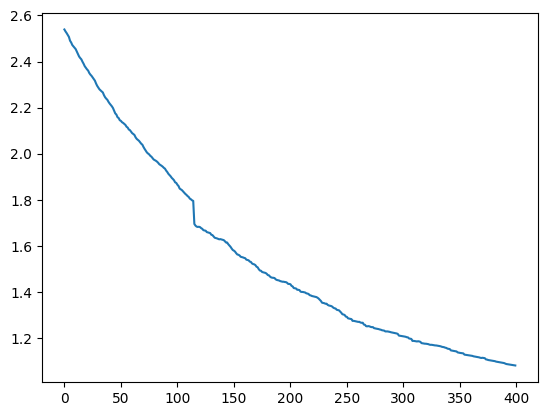

In [ ]:
A0 = xtrain_.T                                          # Damos los valores iniciales, es decir, los elementos de train
Y = np.array(train_label)
A, nn = ForwardPass(A0, nn_red)                         # Obtenemos la lista de prediccion y la informacion de cada parametro de cada layer para actualizarlo luego
j = CostFunction(A, Y)                                  # Obtenemos el coste de la primera iteracion
J=[]
J.append(j)                                             # Guardamos el coste de la primera iteracion
learning_rate=0.002

for i in range (1,400):                                 # Numero de veces que queremos hacer el backwards propagation
  nn = BackwardsPropagation(A, Y, nn)                   # Pasamos lo predicho, lo que deberia ser y la estructura de la red anterior
  nn = update_params(nn,learning_rate)                  # Empleando la informacion de derivadas en el paso anterior actualizamos los parametros de la red
  A, nn = ForwardPass(A0, nn)                           # Ahora con los datos iniciales de la imagenes y la red actualizada volvemos a generar prediccion y guardar la info
  j= CostFunction(A, Y)                                 # Comparamos la preddiccion actualizada y la informacion real de entrenamiento
  J.append(j)                                           # Agregamos el coste actualizado

plt.plot(J)                                             # Funcion de coste para cada iteracion, evidentemente, se minimiza

# AHORA CON LOS DATOS DE TEST

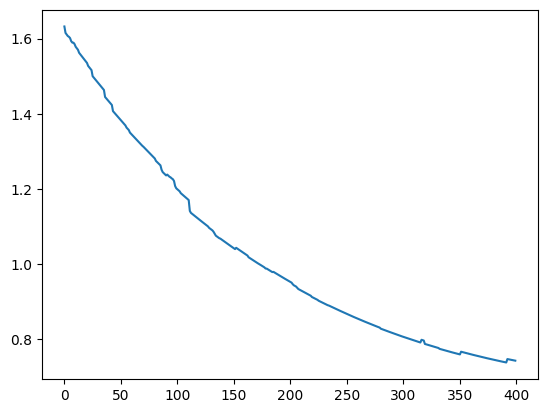

In [ ]:
A0 = xtest_.T
Y = np.array(test_label)
A, nn = ForwardPass(A0, nn)
j = CostFunction(A, Y)
J=[]
J.append(j)
learning_rate=0.002

for i in range (1,400):
  nn = BackwardsPropagation(A, Y, nn)
  nn = update_params(nn,learning_rate)
  A, nn = ForwardPass(A0, nn)
  j= CostFunction(A, Y)
  J.append(j)

plt.plot(J)

Parece no haber problema, esta minimizando el coste entre la prediccion y lo que deberia ser segun el test_label. En ocasiones no logra seguir minimizando el coste y sube un rato